In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
x, y = pkl.load(open('../data/yearly_24_train_line.pkl', 'rb'))

x.shape, y.shape

((176595, 18), (176595, 6))

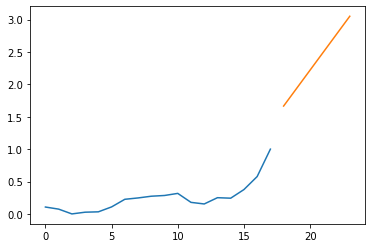

In [23]:
i = 8
plt.plot(range(18), x[i])
plt.plot(range(18, 24), y[i])